In [ ]:
import os
import numpy as np

import torchvision
from torchvision import datasets, transforms

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn.functional as F
import torch.nn as nn

from datetime import datetime
from torchmetrics import JaccardIndex

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
batch_size = 4
# num_frames = 22
num_classes = 49
input_size = (160, 240)

device_ids = [i for i in range(torch.torch.cuda.device_count())]

In [ ]:
device_ids

[0, 1]

In [ ]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, data_path, transform):
        
        self.data_path = data_path
        
        self.files = os.listdir(data_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        
        video_path = f"{self.data_path}/{self.files[i]}"
        frames = []

        for j in range(0, 22):
            frame = Image.open(f"{video_path}/image_{j}.png")
            frames.append(self.transform(frame.convert('RGB')))

        masks = torch.from_numpy(np.load(f"{video_path}/mask.npy"))

        return torch.stack(frames), masks

In [ ]:
trainset = VideoDataset("./Dataset_Student/train", transforms.ToTensor())
valset = VideoDataset("./Dataset_Student/val", transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

In [ ]:
from pytorch_unet.unet.unet_parts import Down, Up, OutConv, DoubleConv

class ShallowUNet(nn.Module):
    '''
        Input dim: (batch_size*num_frames, num_channels, image_height, image_width)
        output dim: (batch_size*num_frames, num_classes, image_height, image_width)
    '''
    def __init__(self, n_channels, n_classes=49, bilinear=False):
        
        super(ShallowUNet, self).__init__()
        
        factor = 2 if bilinear else 1
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
                
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

In [ ]:
def decoder_output_to_mask(output, mask_values=list(range(49))):
    
    mask = output.argmax(dim=1)
    out_tensor=mask[0].squeeze()

    mask = mask[0].long().squeeze().numpy()
    out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)
    
    for i, v in enumerate(mask_values):
        out[mask == i] = v
        
    return Image.fromarray(out),output

In [ ]:
model = nn.DataParallel(ShallowUNet(3).cuda(), device_ids=device_ids).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

In [ ]:
# tin = torch.randn(1, 22, 3, 160, 240)
# tin = tin.permute(0, 2, 1, 3, 4)  # Reshape to (batch_size, num_channels, num_frames, height, width)
# tin = tin.reshape(-1, 3, 160, 240)

# tout = model(tin)
# tout.shape

In [ ]:
from pytorch_unet.utils.dice_score import dice_loss

def train_model(save_ckpt):

    model.train()

    correct, total, total_loss = 0, 0, 0
    j_ind = 0 

    for i, (images, masks) in enumerate(train_dataloader):

        optimizer.zero_grad()

        if( i % 10 == 0):
            print(i, end="  ")

        B, N, C, H, W = images.shape

        images = images.permute(0, 2, 1, 3, 4).reshape(-1, C, H, W).cuda()
        masks = masks.reshape(-1, H, W).long().cuda()

        pred_masks = model(images)

        loss = criterion(pred_masks, masks)
        
        loss += dice_loss(
            F.softmax(pred_masks, dim=1).float(),
            F.one_hot(masks, model.module.n_classes).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        grad_scaler.step(optimizer)
        grad_scaler.update()

#         j_ind = jaccard(pred_masks, masks)

        b, h, w = masks.shape
        correct += torch.sum(pred_masks.argmax(dim=1).squeeze() == masks)
        total += b*h*w

#         loss.backward()
#         optimizer.step()

        total_loss += loss.item()

    if(save_ckpt):
        torch.save(model.state_dict(), 'unet_segmentor.pth')

    print(f"\n\nEpoch: {e+1}, Loss: {total_loss}, Correct: {correct/total}\n")


def evaluate_model():
    
    correct, total, val_loss = 0, 0, 0

    model.eval()
    with torch.no_grad():

        for i, (images, masks) in enumerate(val_dataloader):
            
            if i == 50:
                break
            
            B, N, C, H, W = images.shape

            images = images.permute(0, 2, 1, 3, 4).reshape(-1, C, H, W).cuda()
            masks = masks.reshape(-1, 1, H, W).long().cuda()

            pred_masks = model(images)

            val_loss += F.cross_entropy(pred_masks, masks.squeeze(1))
            
            correct += torch.sum(pred_masks.argmax(dim=1).squeeze() == masks)
            total += B * N * H * W

        print(f"Val Loss: {val_loss}, Accuracy: {correct/total}\n")
        
    mask, _ = decoder_output_to_mask(pred_masks.cpu())
    return mask

In [ ]:
num_epochs = 10

jaccard = JaccardIndex(task="multiclass", num_classes=49)

t1 = datetime.now()

for e in range(num_epochs):
    train_model(True)
    
    if e%5 == 0:
        print(evaluate_model())

print(evaluate_model())

print(f"Training took time: {datetime.now() - t1}")

0  10  20  30  40  50  60  70  80  

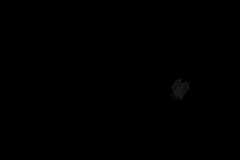

In [ ]:
mask, _ = decoder_output_to_mask(pred_masks.cpu())
mask